# Use of UNet

In [7]:
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv1d, ReLU, BatchNorm1d, MaxPool1d, Flatten, Linear, Upsample
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
class Conv1D_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Conv1D_Layer, self).__init__()
        self.conv1d = Conv1d(in_channels, out_channels, kernel_size, padding)
        self.relu = Sigmoid()
        self.batchnorm = BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.Sigmoid(),
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.Sigmoid(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Conv1d(64, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [22]:
# Define material properties
Vs_values = np.array([140,250,1000,1500,2000,100,500,800,950,2500], dtype=float)
f_values = np.array([1, 1.5, 1.75, 2.25, 3], dtype=float)
t_values = np.linspace(0.5, 2.5, 10)

# Create a list of all possible combinations of Vs, f, and t
Vs_val, f_val, t_val = np.meshgrid(Vs_values, f_values, t_values, indexing='ij')
Vs_val = Vs_val.flatten()
f_val = f_val.flatten()
t_val = t_val.flatten()

# Create array with the combinations
data = np.array([Vs_val, f_val, t_val]).T

# Read all csv files from folder
folder_path = r"FLAC\FLAC2D - Case 1a\data"
files = os.listdir(folder_path)
files = [f for f in files if f.endswith('.csv')]

In [27]:
# Create DataSet class
class MyDataset(Dataset):
    def __init__(self, data, folder_path):
        self.data = data
        self.folder_path = folder_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read the file
        file = files[idx]
        df = pd.read_csv(os.path.join(self.folder_path, file))
        # Get the data
        target = df.values[:, 2:]
        # Get the target
        input_2 = self.data[idx]

        # Get the additional input
        freq1 = input_2[1]
        t01 = input_2[2]
        t = df.values[:, 0]
        wave = -2*freq1**2*np.pi**2*np.exp(-freq1**2*np.pi**2*(t01 - t)**2)*(t01 - t)*(2*freq1**2*np.pi**2*t01**2 - 4*freq1**2*np.pi**2*t01*t + 2*freq1**2*np.pi**2*t**2 - 3)
        input_1 = wave
    
        # Get final input
        input_2 = input_2[0] * np.ones((30,))

        # Convert to tensor
        input_1 = torch.tensor(input_1, dtype=torch.float32)
        input_2 = torch.tensor(input_2, dtype=torch.float32)
        # Concat inputs
        input_total = torch.cat((input_1, input_2), 0).unsqueeze(1)
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_total, target

In [28]:
dataset = MyDataset(data, folder_path)

In [29]:
# Define the sizes for training, validation, and testing sets
from torch.utils.data import DataLoader, random_split

train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(train_size, val_size, test_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check the first batch of the training set
for i, (input_1, target) in enumerate(train_loader):
    print("Training set:", input_1.shape, target.shape)
    break

# Check the first batch of the validation set
for i, (input_1, target) in enumerate(val_loader):
    print("Validation set:", input_1.shape, target.shape)
    break

# Check the first batch of the testing set
for i, (input_1, target) in enumerate(test_loader):
    print("Testing set:", input_1.shape, target.shape)
    break

450 25 25
Training set: torch.Size([2, 1530, 1]) torch.Size([2, 1500, 1])
Validation set: torch.Size([2, 1530, 1]) torch.Size([2, 1500, 1])
Testing set: torch.Size([2, 1530, 1]) torch.Size([2, 1500, 1])


In [32]:
model = UNet(in_channels=1530, out_channels=1500)
pred = model(input_1)
print(pred.shape, target.shape, input_1.shape)
assert pred.shape == target.shape

torch.Size([2, 1500, 1]) torch.Size([2, 1500, 1]) torch.Size([2, 1530, 1])


In [41]:
from tqdm import trange

# Training function
def train(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-3, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in trange(num_epochs, desc="Training", unit="epoch"):
        model.train()
        train_loss = 0
        for input_1, target in train_loader:
            input_1 = input_1.to(device)
            target = target.to(device)
            # Forward pass
            pred = model(input_1)
            loss = criterion(pred, target)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Optimize
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for input_1, target in val_loader:
                input_1 = input_1.to(device)
                target = target.to(device)
                pred = model(input_1)
                loss = criterion(pred, target)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    return train_losses, val_losses, model
        

In [42]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [46]:
# Start training

model = UNet(1530,1500).to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))
num_epochs = 100


In [47]:
train_losses, val_losses, model = train(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=1e-3, device=device)

Training:   1%|          | 1/100 [00:02<04:19,  2.62s/epoch]

Epoch 0, Train Loss: 6.882585006290012, Val Loss: 7.71866512298584


Training:  11%|█         | 11/100 [00:38<05:36,  3.78s/epoch]

Epoch 10, Train Loss: 6.676355928844876, Val Loss: 7.456470049344576


Training:  21%|██        | 21/100 [01:09<04:17,  3.25s/epoch]

Epoch 20, Train Loss: 6.642046396467421, Val Loss: 7.445951608511118


Training:  31%|███       | 31/100 [01:46<04:30,  3.93s/epoch]

Epoch 30, Train Loss: 6.627397695117526, Val Loss: 7.425530543694129


Training:  41%|████      | 41/100 [02:23<03:48,  3.88s/epoch]

Epoch 40, Train Loss: 6.621230638292101, Val Loss: 7.421956905951867


Training:  51%|█████     | 51/100 [03:01<03:04,  3.77s/epoch]

Epoch 50, Train Loss: 6.614143583509657, Val Loss: 7.416110405555139


Training:  61%|██████    | 61/100 [03:41<02:27,  3.78s/epoch]

Epoch 60, Train Loss: 6.6111434841156, Val Loss: 7.530754199394813


Training:  71%|███████   | 71/100 [04:25<01:58,  4.08s/epoch]

Epoch 70, Train Loss: 6.608798348108928, Val Loss: 7.613828915816087


Training:  81%|████████  | 81/100 [05:03<01:10,  3.69s/epoch]

Epoch 80, Train Loss: 6.607639223734537, Val Loss: 7.369074784792387


Training:  91%|█████████ | 91/100 [05:46<00:38,  4.23s/epoch]

Epoch 90, Train Loss: 6.606080010732015, Val Loss: 7.5244041956388035


Training: 100%|██████████| 100/100 [06:20<00:00,  3.81s/epoch]


Text(0.5, 1.0, 'Loss vs Epoch')

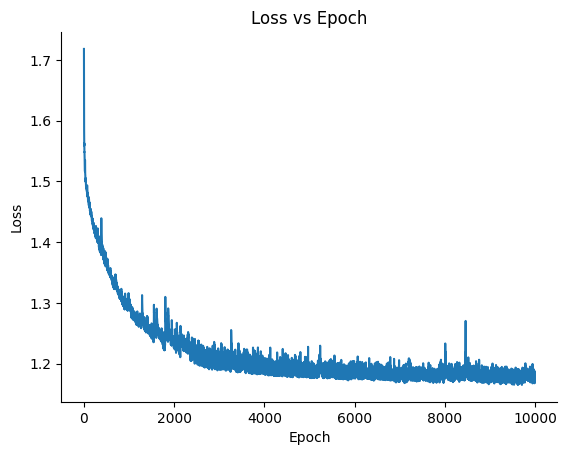

In [354]:
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="Val Loss")

plt.yscale("log")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()



In [49]:
def test(model, test_loader, device="cpu"):
    criterion = nn.MSELoss()
    model.to(device)
    model.eval()

    test_loss = 0
    predictions = []
    with torch.no_grad():
        for input_1, target in test_loader:
            input_1 = input_1.to(device)
            target = target.to(device)
            pred = model(input_1)
            loss = criterion(pred, target)
            test_loss += loss.item()
            predictions.append(pred)

    test_loss /= len(test_loader)

    return test_loss, predictions

            

In [50]:
predictions, test_loss = test(model, test_loader, device=device)
print(f"Test Loss: {test_loss}")

Test Loss: [tensor([[[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]],

        [[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]]], device='cuda:0'), tensor([[[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]],

        [[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]]], device='cuda:0'), tensor([[[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]],

        [[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]]], device='cuda:0'), tensor([[[0.0013],
         [0.0013],
         [0.0013],
         ...,
         [0.0013],
         [0.0013],
         [0.0013]],

        [[0.0013],
     

In [48]:
# Plot the first prediction
predictions

NameError: name 'predictions' is not defined